In [2]:
# importing functions & libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
import shap



# loading the jorunal / mood data
mj_data = pd.read_csv("Mood_Journal_Data_Expanded.csv")
print(mj_data) # displaying the data so we can see any possible errors or mistakes in loading the data

                                         Journal Entry  Mood
0    The hum of the ceiling fan created a steady rh...  Calm
1    A warm blanket draped over my shoulders as I r...  Calm
2    The morning fog hung low over the fields. I wa...  Calm
3    The scent of lavender filled the room from a n...  Calm
4    The cat purred softly beside me. I stroked her...  Calm
..                                                 ...   ...
795  Being around people today only reminded me how...   Sad
796  I cried quietly tonight without really knowing...   Sad
797  I tried to keep busy today, but the sadness ke...   Sad
798  Scrolling through old photos made me miss the ...   Sad
799  I woke up this morning with a heaviness I coul...   Sad

[800 rows x 2 columns]


In [3]:
# splitting the data between features (journal entries) and outcome (mood)
x = mj_data["Journal Entry"]
y = mj_data["Mood"]

# creating a pipeline model that words with text data, using the LogisticRegession model
model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter = 1000))
])

# creating multiple splits so we can find an average accuracy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 24)

# testing the model using our cross validation splits
scores = cross_val_score(model, x, y, cv = cv, scoring = "accuracy")

# printing accuracy and other related statistics / values
print("Cross-Validation Accuracies", scores)
print("Mean Accuracy", scores.mean())
print("Std Deviation", scores.std())

# fitting the training to the model and saving so that when copied somewhere else the model is already trained
model.fit(x,y)
joblib.dump(model, "mood_journal_model.joblib")

Cross-Validation Accuracies [0.975   0.9875  0.94375 0.9875  0.99375]
Mean Accuracy 0.9775
Std Deviation 0.017940875118009177


['mood_journal_model.joblib']

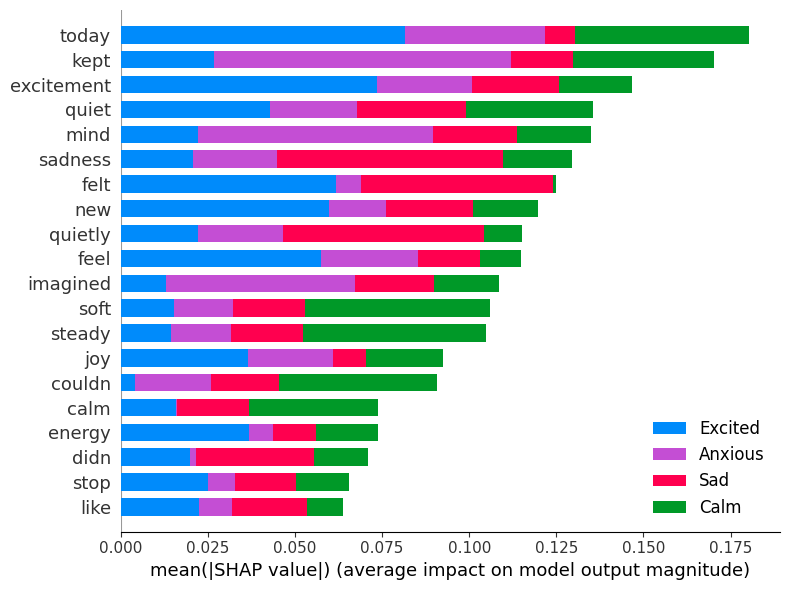

In [27]:
# Extract the trained TF-IDF vectorizer and Logistic Regression classifier from the pipeline
vectorizer = model.named_steps["tfidf"]
classifier = model.named_steps["clf"]

# Transform the raw text data into TF-IDF vectors (numerical features)
X_tfidf = vectorizer.transform(x)

# Create a SHAP explainer that will compute feature importance scores for the classifier, using the TF-IDF feature space
explainer = shap.LinearExplainer(classifier, X_tfidf, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_tfidf)

# Get the actual class labels from the classifier ("sad", "calm", "excited", "anxious")
class_names = classifier.classes_

# Creating the SHAP summary plot
shap.summary_plot(
    shap_values,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=class_names,
    plot_size = (8,6),
)